In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [106]:
import rasterio
from torch.utils.tensorboard import SummaryWriter

In [5]:

import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
from skimage.external import tifffile as sktif

# import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

W0907 17:15:16.842847 140261047789376 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W0907 17:15:16.987268 140261047789376 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [6]:
import sys
sys.path.append("./cresi/src")


In [116]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")
mumbai = data_dir/"AOI_8_Mumbai"
ms_mumbai = mumbai/"MS"
ps_rgb_mumbai = mumbai/"PS-RGB"

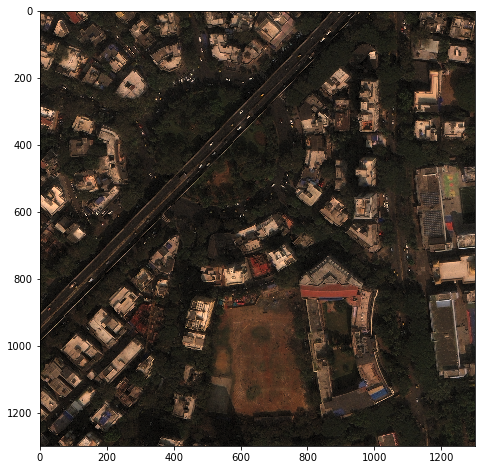

In [8]:
ps_rgb_list = ps_rgb_mumbai.ls()
demo_im = sktif.imread(str(ps_rgb_mumbai/"SN5_roads_train_AOI_8_Mumbai_PS-RGB_chip19.tif"))
plt.figure(figsize=(8,8))
plt.imshow(demo_im)

In [19]:
mask_df =pd.read_csv( mumbai / "train_AOI_8_Mumbai_geojson_roads_speed_wkt_weighted.csv")
mask_df.head()

,ImageId,WKT_Pix,length_m,travel_time_s
0,AOI_8_Mumbai_chip0,"LINESTRING (0 32.22116693202406, 192.200136788...",56.809,4.236316
1,AOI_8_Mumbai_chip0,LINESTRING (458.3862400762737 13.2714583603665...,78.722,5.870395
2,AOI_8_Mumbai_chip0,LINESTRING (201.9495008252561 163.568223531357...,43.191,3.220805
3,AOI_8_Mumbai_chip0,"LINESTRING (192.2208984196186 0, 192.342463284...",8.029,0.598732
4,AOI_8_Mumbai_chip0,LINESTRING (728.7709745801985 0.42649332806468...,79.967,5.963236


In [9]:
mask_folder = mumbai / "masks"
mask_folder.mkdir(exist_ok=True)

In [44]:
#using the rgb images for now
num_channels=3
burn_value = 1
# previous spacenet challenge winner found using 2m  to be quite effective, however the crs here is 4326 which 
# can't be used to create a mask based on distance...
road_mask_width = 20

def create_mask(img_id, road_mask_width=20):
    mask_fname = mumbai / "geojson_roads_speed" / f"SN5_roads_train_AOI_8_Mumbai_geojson_roads_speed_{img_id}.geojson"
    outfile = mask_folder / f"{img_id}.png"
    reference_im = rasterio.open(str(ps_rgb_mumbai/f"SN5_roads_train_AOI_8_Mumbai_PS-RGB_{img_id}.tif"))
    road_mask = np.zeros((1300,1300))
    df = gpd.read_file(mask_fname)
    if len(df) > 0:
        
        try:
            road_mask = sol.vector.mask.road_mask(df,
              shape=(1300,1300),reference_im=reference_im,
              width=road_mask_width, meters=False, burn_value=burn_value, out_type=int)


        except Exception as e:
            print(e, mask_fname)
            pass
    skimage.io.imsave(outfile, road_mask.astype('uint8') )

In [8]:
# create_mask("chip19", road_mask_width=3)
img_id = "chip19"
mask_fname = mumbai / "geojson_roads_speed" / f"SN5_roads_train_AOI_8_Mumbai_geojson_roads_speed_{img_id}.geojson"
outfile = mask_folder / f"{img_id}.png"
road_mask = np.zeros((1300,1300))
df = gpd.read_file(mask_fname)
df.head()


,OBJECTID,bridge,highway,osm_id,surface,lanes,inferred_speed_mph,inferred_speed_mps,origarea,origlen,partialDec,truncated,geometry
0,1094,None,secondary,683675331.0,paved,2,35.0,15.6464,0.0,0,1,0,LINESTRING (72.85742577561622 19.0243364093124...
1,1097,None,secondary,683675334.0,paved,4,45.0,20.1168,0.0,0,1,0,LINESTRING (72.85692370000004 19.0254491000000...
2,1098,None,secondary,683675335.0,paved,2,35.0,15.6464,0.0,0,1,0,LINESTRING (72.85749752242104 19.0248466656394...
3,1124,None,motorway,683675361.0,paved,2.5,55.0,24.5872,0.0,0,1,0,LINESTRING (72.85645545632443 19.0279899859037...
4,1126,None,motorway,683675362.0,paved,1.5,55.0,24.5872,0.0,0,1,0,LINESTRING (72.85652687643713 19.0279899859037...


In [11]:
test_im =

In [64]:
test_im.crs

CRS.from_epsg(4326)

In [61]:
geo_df = sol.vector.polygon.geojson_to_px_gdf(
    str(mumbai / "geojson_roads_speed" / f"SN5_roads_train_AOI_8_Mumbai_geojson_roads_speed_chip19.geojson"),
    str(ps_rgb_mumbai/"SN5_roads_train_AOI_8_Mumbai_PS-RGB_chip19.tif"))

def crs_is_metric(gdf):
    """Check if a GeoDataFrame's CRS is in metric units."""
    units = str(sol.utils.geo.gdf_get_projection_unit(gdf)).strip().lower()
    if units in ['"meter"', '"metre"', "'meter'", "'meter'",
                 'meter', 'metre']:
        return True
    else:
        return False

In [62]:
crs_is_metric(df)

False

In [26]:
img_ids = [x.name.split('_')[-1].replace('.tif', '') for x in ps_rgb_list]

In [19]:
num_channels=3
burn_value = 1
# previous spacenet challenge winner found this to be quite effective

road_mask = sol.vector.mask.road_mask(df,
          shape=(1300,1300),reference_im=test_im,
          width=10, meters=False, burn_value=burn_value, out_type=int)

road_mask2 = sol.vector.mask.road_mask(df,
          shape=(1300,1300),reference_im=test_im,
          width=15, meters=False, burn_value=burn_value, out_type=int)

road_mask3 = sol.vector.mask.road_mask(df,
          shape=(1300,1300),reference_im=test_im,
          width=20, meters=False, burn_value=burn_value, out_type=int)

road_mask4 = sol.vector.mask.road_mask(df,
          shape=(1300,1300),reference_im=test_im,
          width=30, meters=False, burn_value=burn_value, out_type=int)


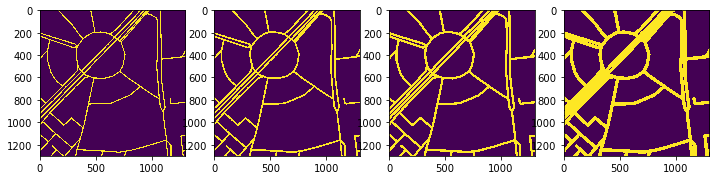

In [20]:
fig, axs = plt.subplots(1,4, figsize=(12,4))
axs = axs.ravel()
axs[0].imshow(road_mask)
axs[1].imshow(road_mask2)
axs[2].imshow(road_mask3)
axs[3].imshow(road_mask4)

using a pixel width of 20 seems to give a good tradeoff between the roads all merging together and being too thin

In [45]:
%time _= [create_mask(img_id) for img_id in img_ids]

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip64.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip68.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip427.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip983.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip710.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip831.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip306.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip187.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip973.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip96.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip48.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip758.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip435.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip18.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip111.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip857.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip493.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip781.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip939.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip91.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip426.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip148.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip76.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip993.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip12.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip685.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip184.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip336.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip933.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip929.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip324.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip772.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip839.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip329.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip792.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip537.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip689.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip888.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip796.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip524.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip317.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip683.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip141.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip78.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip588.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip125.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip104.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip791.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip632.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip321.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip572.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip356.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip846.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip343.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip692.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip284.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip188.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip175.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip734.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3

CPU times: user 50.7 s, sys: 440 ms, total: 51.1 s
Wall time: 1min 1s


/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip779.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: /media/wwymak/Storage/spacenet_roads/AOI_8_Mumbai/masks/chip934.png is a low contrast image
  warn('%s is a low contrast image' % fname)


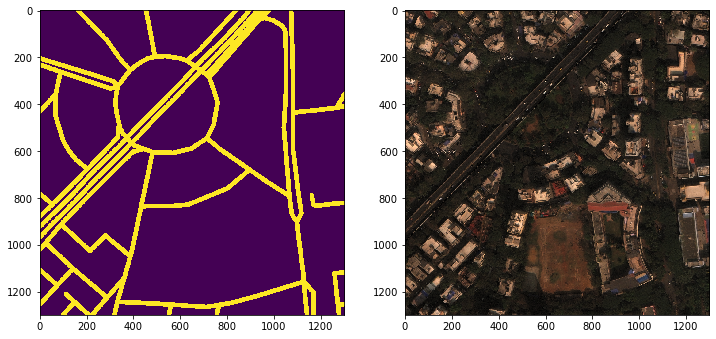

In [47]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs = axs.ravel()
axs[0].imshow(skimage.io.imread(str(mask_folder/"chip19.png")))
axs[1].imshow(sktif.imread(str(ps_rgb_mumbai/"SN5_roads_train_AOI_8_Mumbai_PS-RGB_chip19.tif")))

In [10]:
from pytorch_zoo.unet import Resnet34_upsample, Resnet

In [11]:
model = Resnet34_upsample(num_classes=8, num_channels=3)

weights_path = Path("cresi") /"results"/"weights"/"cresi_state_dict2.pth"
model.load_state_dict(torch.load(weights_path))
model.eval()

Resnet34_upsample(
  (bottlenecks): ModuleList(
    (0): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (2): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (3): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (decoder_stages): ModuleList(
    (0): UnetDecoderBlock(
      (layer): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inpla

In [23]:
test_arr = sktif.imread(str(ps_rgb_mumbai/"SN5_roads_train_AOI_8_Mumbai_PS-RGB_chip19.tif"))
test_tensor = torch.from_numpy(test_arr).float().permute((2,0,1)).cuda()
test_tensor = test_tensor[None, :]
test_tensor = F.pad(test_tensor, (22,22, 22,22))
test_tensor.shape

torch.Size([1, 3, 1344, 1344])

In [24]:
model.cuda()

Resnet34_upsample(
  (bottlenecks): ModuleList(
    (0): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (2): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (3): ConvBottleneck(
      (seq): Sequential(
        (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (decoder_stages): ModuleList(
    (0): UnetDecoderBlock(
      (layer): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU(inpla

In [25]:
pred = model(test_tensor)
pred.shape

torch.Size([1, 8, 1344, 1344])

In [91]:
y = torch.ones(pred.shape).cuda()
b = torch.where(pred > 0, y, pred)
b2 = b.cpu().detach().numpy()
b2.shape

(1, 8, 1344, 1344)

In [72]:
pred1 = torch.sigmoid(pred[:,7,:,:])
pred_mask = pred1.cpu().detach().numpy()
pred_mask.shape

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(1, 1344, 1344)

In [92]:
a = np.rollaxis(b2.squeeze(), 0,3)
a.max(), a.min(), a.shape

(1.0, -12134.997, (1344, 1344, 8))

In [85]:
b = (a * 255).astype(np.uint8)

In [93]:
len(np.argwhere(a > 0))

2

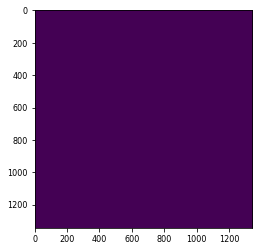

In [77]:
plt.imshow(b)

In [ ]:
def eval_roads(config, paths, fn_mapping, image_suffix, save_dir, test=True,
               num_channels=3, weight_dir='', nfolds=4, 
               save_im_gdal_format=False):
    
    #t0 = time.time()
    ds = ReadingImageProvider(RawImageTypePad, paths, fn_mapping, 
                              image_suffix=image_suffix, num_channels=num_channels)
    
    folds = [([], list(range(len(ds)))) for i in range(nfolds)]
    num_workers = 0 if os.name == 'nt' else 2
    #print ("folds:", folds)
    print ("num_workers:", num_workers)
    keval = FullImageEvaluator(config, ds, save_dir=save_dir, test=test, 
                               flips=3, num_workers=num_workers, 
                               border=config.padding,
                               save_im_gdal_format=save_im_gdal_format)
    for fold, (t, e) in enumerate(folds):
       print ("fold:", fold)
       if args.fold is not None and int(args.fold) != fold:
           print ("ummmm....")
           continue
       keval.predict(fold, e, weight_dir)
           
    #t1 = time.time()
    #nfiles = len(os.listdir(args.path_images_8bit))
    #print ("Time to run", len(folds), "folds for", nfiles, "=", t1 - t0, "seconds")
    return folds

In [115]:
test_tensor.shape

torch.Size([1, 3, 1344, 1344])

In [105]:
np.argwhere(skimage.io.imread(str(mask_folder/"chip19.png")) > 0).shape

(292144, 2)

In [ ]:
def gamma_correction(image, gamma=1.66):
    '''https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/'''
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def calc_rescale(im_file_raw, m, percentiles):
    srcRaster = gdal.Open(im_file_raw)
    for band in range(1, 4):
        b = srcRaster.GetRasterBand(band)
        band_arr_tmp = b.ReadAsArray()
        bmin = np.percentile(band_arr_tmp.flatten(),
                             percentiles[0])
        bmax= np.percentile(band_arr_tmp.flatten(),
                            percentiles[1])
        m[band].append((bmin, bmax))

    # for k, v in m.items():
    #     print(k, np.mean(v, axis=0))
    return m



In [114]:

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

writer.add_graph(model, test_tensor, verbose=True)
writer.close()

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/torch/jit/__init__.py:914: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[0, 7, 1337, 1343] (-0.6258513331413269 vs. -0.6258310675621033) and 1 other locations (0.00%)
  check_tolerance, _force_outplace, True, _module_class)


graph(%self : ClassType<Resnet34_upsample>,
      %input.1 : Float(1, 3, 1344, 1344)):
  %1 : ClassType<ModuleList> = prim::GetAttr[name="bottlenecks"](%self)
  %2 : ClassType<ConvBottleneck> = prim::GetAttr[name="0"](%1)
  %3 : ClassType<Sequential> = prim::GetAttr[name="seq"](%2)
  %4 : ClassType<Conv2d> = prim::GetAttr[name="0"](%3)
  %weight.74 : Tensor = prim::GetAttr[name="weight"](%4)
  %6 : Tensor = prim::GetAttr[name="bias"](%4)
  %8 : ClassType<ConvBottleneck> = prim::GetAttr[name="1"](%1)
  %9 : ClassType<Sequential> = prim::GetAttr[name="seq"](%8)
  %10 : ClassType<Conv2d> = prim::GetAttr[name="0"](%9)
  %weight.76 : Tensor = prim::GetAttr[name="weight"](%10)
  %12 : Tensor = prim::GetAttr[name="bias"](%10)
  %14 : ClassType<ConvBottleneck> = prim::GetAttr[name="2"](%1)
  %15 : ClassType<Sequential> = prim::GetAttr[name="seq"](%14)
  %16 : ClassType<Conv2d> = prim::GetAttr[name="0"](%15)
  %weight.78 : Tensor = prim::GetAttr[name="weight"](%16)
  %18 : Tensor = prim::GetAtt

In [109]:
from torchviz import make_dot

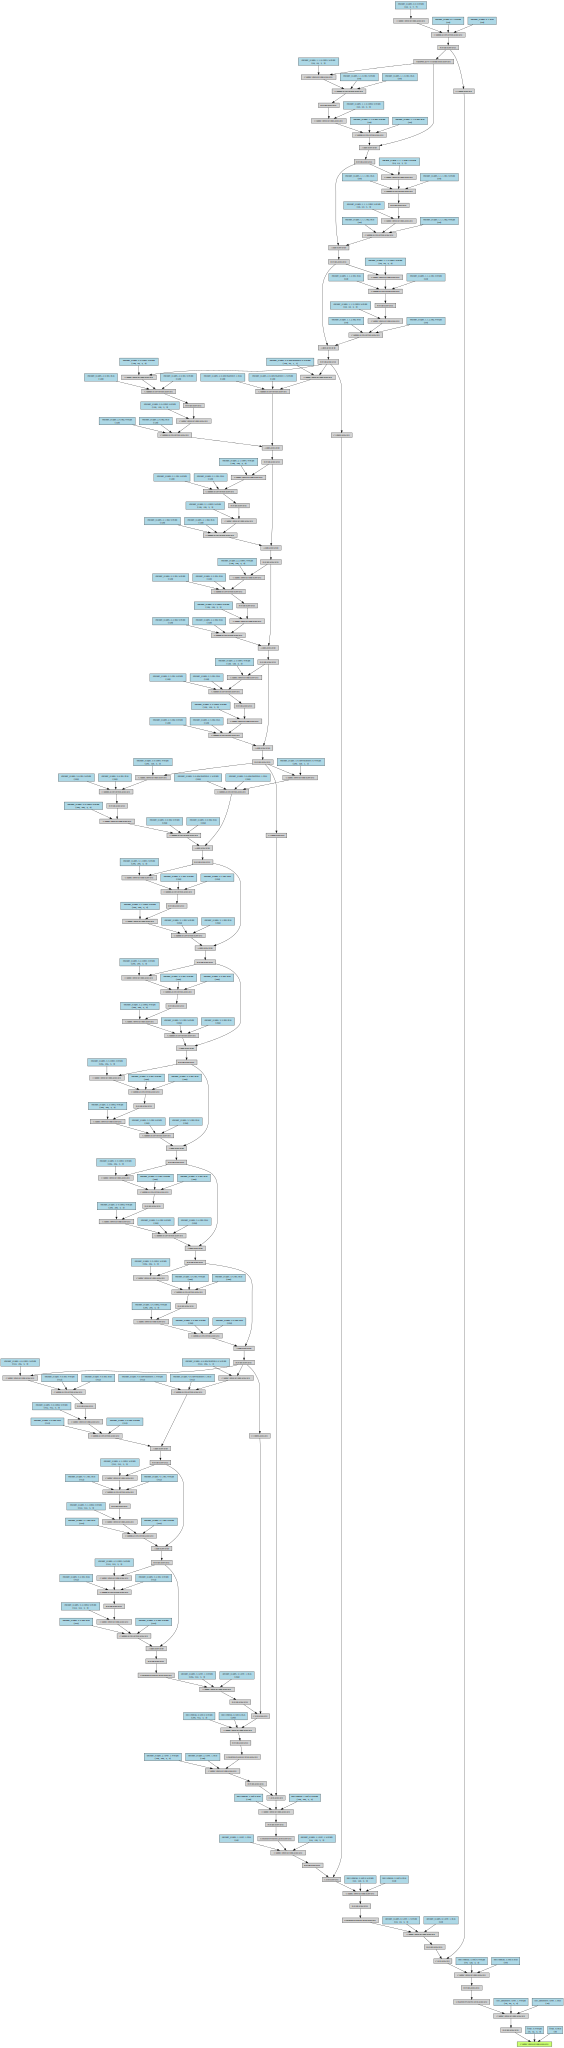

In [111]:
make_dot(pred, params=dict(model.named_parameters()))